Import Necessary Libraries:

---



In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import Image
import IPython.display

In [ ]:
%tensorflow_version 1.x
import tensorflow as tf

from tensorflow.python.keras.preprocessing import image as kp_image
from tensorflow.python.keras import models 
from tensorflow.python.keras import losses
from tensorflow.python.keras import layers
from tensorflow.python.keras import backend as K

In [ ]:
tf.enable_eager_execution()
print("Eager execution: {}".format(tf.executing_eagerly()))

Eager execution: True


Mount Drive for Image loading from Drive

---



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Image Path Fetch

In [ ]:
#Image path Target: Information Image and Style: What kind of transformation Image
TargetPath = '/content/drive/MyDrive/Project Sem 6/CV/Assignment-6&7/content.jpg' # Change it with your path
StylePath = '/content/drive/MyDrive/Project Sem 6/CV/Assignment-6&7/styleim.jpg'

For resizing the Target Image

In [ ]:
img = cv2.imread(TargetPath)

img = tf.image.resize(img,(512,512))
img = (np.uint8)(img)
filename = 'contentn.jpg'
cv2.imwrite(filename, img)
TargetPath = 'contentn.jpg'

Model load: Load Images in specific resized format

---



In [ ]:
def loadImage(image_path):
  # Read Image
  image = cv2.imread(image_path) 
  # BGR to RGB conversion
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  #Fetch Shapes of the image

  image = tf.image.resize(image, (512,512))
  image = (np.uint8)(image)
  image = np.expand_dims(image, axis=0)
  return image

In [ ]:
def imshow(img, title=None):
  # Remove extra dimension 
  img = np.squeeze(img, axis=0)
  img = img.astype('uint8')
  # Show the image
  plt.imshow(img)
  if title is not None:
    plt.title(title)
  plt.imshow(img)

See the effect by simple addition of both the images

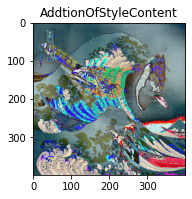

In [ ]:
style = cv2.imread(StylePath)
content = cv2.imread(TargetPath)
img = (np.uint8)(tf.image.resize(style,(400,400)))+(np.uint8)(tf.image.resize(content,(400,400)))
plt.subplot(1, 2, 1)

plt.imshow(img)
plt.title('AddtionOfStyleContent')
plt.savefig('NSTbySimpleAddition')

Pre-process and De-process image by inbuilt function (CNN Architecture)

In [ ]:
# Preprocess and De-process for VGG19 model

def preProcessing(imgPath):
  img = loadImage(imgPath)
  img = tf.keras.applications.vgg16.preprocess_input(img)        #tf.keras.applications.resnet50.preprocess_input(img)#tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
# Clip it between 0-255
def deProcessing(img):
  img = np.squeeze(img, 0)
  
  # perform the inverse of the preprocessing step
  img[:, :, 0] += 103.939
  img[:, :, 1] += 116.779
  img[:, :, 2] += 123.68
  img = img[:, :, ::-1]

  img = np.clip(img, 0, 255).astype('uint8') # to limiy array between 0-255
  return img

Extract model summary

---



In [ ]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')#tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')#tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')# 
vgg.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

The name of those layers, from which we want feature extraction for Target and style images


In [ ]:
# Target Layer For VGG16&19
targetLayer = ['block5_conv2'] 

# Style Layers for VGG16&19
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

'''
# Target Layer For ResNet-50
targetLayer = ['conv5_block3_3_conv'] 

# Style Layers for ResNet-50
style_layers = ['conv1_conv', 'conv2_block1_1_conv','conv2_block2_1_conv','conv3_block1_1_conv','conv3_block3_1_conv','conv4_block1_1_conv','conv4_block3_1_conv','conv5_block1_1_conv','conv5_block3_1_conv']

# For Inceptionnet
targetLayer=['conv2d']

style_layers=['conv2d_2', 'conv2d_7', 'conv2d_10','conv2d_17','conv2d_24']
'''
styleLayerNo = len(style_layers)
targetLayerNo = len(targetLayer)


Model Implementation VGG-16

---



In [ ]:
def modelImplementation():
  vgg = tf.keras.applications.vgg16.VGG16(include_top=False, weights='imagenet')#tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')##tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')# 
  vgg.trainable = False

  # Fetch Layers
  targetOut = [vgg.get_layer(name).output for name in targetLayer]
  styleOut = [vgg.get_layer(name).output for name in style_layers]
 
  # Add those layers
  Final = styleOut + targetOut
  return models.Model(vgg.input, Final)

Loss Defination

---
Equlidian Distance Measure



In [ ]:
def targetLoss(base, target):
  return tf.reduce_mean(tf.square(target-base))

In [ ]:
def gramMatrix(A):
  # A*A^T
  channels = int(A.shape[-1])
  A = tf.reshape(A, [-1, channels])
  n = tf.shape(A)[0]
  return tf.matmul(A, A, transpose_a=True) / tf.cast(n, tf.float32)


In [ ]:
# From Style Loss formula
def styleLoss(base, target):
  height, width, channels = base.get_shape().as_list()
  style = gramMatrix(base)#compute gram metrix
  
  return tf.reduce_mean(tf.square(style - target)) 

Feture Extraction

---



In [ ]:
def featureRepresentations(model, TargetPath, StylePath):
  #Load the actual image from path
  target = preProcessing(TargetPath)
  style = preProcessing(StylePath)
  
  styleOut= model(style)
  contentOut = model(target)
  
  # Extract layers
  styleFeatures = [layer[0] for layer in styleOut[:styleLayerNo]]
  contentFeatures = [layer[0] for layer in contentOut[styleLayerNo:]]
  return styleFeatures, contentFeatures

Loss computation

---



In [ ]:
def lossComputation(model,loss_weights, init_image, gram_style_features, content_features):
  
  modelOut = model(init_image)
  
  scoreStyle = 0
  scoreContent = 0

  weight_per_style_layer = 1.0 / float(styleLayerNo)
  for target_style, comb_style in zip(gram_style_features, modelOut[:styleLayerNo]):
    scoreStyle += weight_per_style_layer * styleLoss(comb_style[0], target_style)

  weight_per_content_layer = 1.0 / float(targetLayerNo)
  for target_content, comb_content in zip(content_features, modelOut[styleLayerNo:]):
    scoreContent += weight_per_content_layer* targetLoss(comb_content[0], target_content)

  styleWeight, contentWeight = loss_weights
  scoreStyle *= styleWeight
  scoreContent *= contentWeight

  return scoreStyle + scoreContent , scoreStyle, scoreContent

Then computing the gradients is easy:

In [ ]:
def compute_grads(cfg):
  with tf.GradientTape() as tape: 
    all_loss = lossComputation(**cfg)

  loss = all_loss[0]
  return tape.gradient(loss, cfg['init_image']), all_loss

Optimization loop

In [ ]:

def run_style_transfer(TargetPath, StylePath,  iterations=1000,cweight=1e3, sweight=1e-2): 
  model = modelImplementation() 
  for layer in model.layers:
    layer.trainable = False
  


  init_image = preProcessing(TargetPath)
  init_image = tf.Variable(init_image, dtype=tf.float32)

  opt = tf.train.AdamOptimizer(learning_rate=5, beta1=0.99, epsilon=1e-1)

  iter_count = 1
  
  best_loss, best_img = float('inf'), None
  style_features, content_features = featureRepresentations(model, TargetPath, StylePath)
  gram_style_features = [gramMatrix(style_feature) for style_feature in style_features]
  loss_weights = (sweight, cweight)
  cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
  }

 
  intDisp = iterations/(10)
  start_time = time.time()
  global_start = time.time()
  
  norm_means = np.array([103.939, 116.779, 123.68])
  min_vals = -norm_means
  max_vals = 255 - norm_means   
  
  images = []
  for i in range(iterations):
    
    grads, all_loss = compute_grads(cfg)
    loss, style_score, content_score = all_loss
    opt.apply_gradients([(grads, init_image)])
    clipped = tf.clip_by_value(init_image, min_vals, max_vals)
    init_image.assign(clipped)
    end_time = time.time() 
    
    if loss < best_loss:
      best_loss = loss
      best_img = deProcessing(init_image.numpy())

    if i % intDisp== 0:
      start_time = time.time()

      img = init_image.numpy()
      img = deProcessing(img)
      images.append(img)
      IPython.display.clear_output(wait=True)
      IPython.display.display_png(Image.fromarray(img))
      print('Iteration: {}'.format(i))        
      print('Total loss: {:.4e}, ' 
            'style loss: {:.4e}, '
            'content loss: {:.4e}, '
            'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
      
  print('Total time: {:.4f}s'.format(time.time() - global_start))
  IPython.display.clear_output(wait=True)
  plt.figure(figsize=(20,5))
  for i,img in enumerate(images):
      plt.subplot(2,5,i+1)
      plt.imshow(img) 
  return best_img, best_loss 

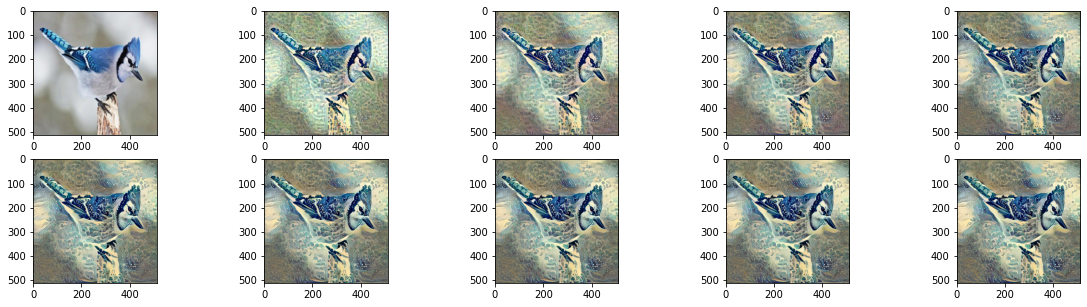

In [ ]:

best, best_loss = run_style_transfer(TargetPath, StylePath, iterations=800)

In [ ]:
# Print the best loss out of it and same  will be best_image
print('Total loss: {:.4e}'.format(best_loss))

Total loss: 1.1566e+05


Output of VGG16

---



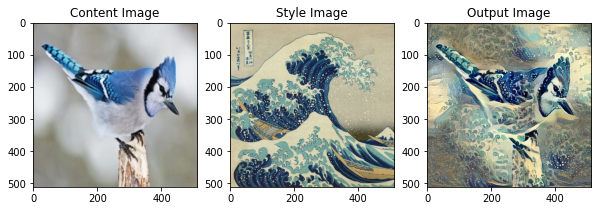

In [ ]:
plt.figure(figsize=(10, 5))
content = loadImage(TargetPath) 
style = loadImage(StylePath)
plt.subplot(1, 3, 1)
imshow(content, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style, 'Style Image')


plt.subplot(1, 3, 3)
plt.imshow(best)
plt.title('Output Image')
plt.savefig('VGG1024')
plt.show()

VGG19

---



In [ ]:
# Preprocess and De-process for VGG19 model

def preProcessing(imgPath):
  img = loadImage(imgPath)
  img = tf.keras.applications.vgg19.preprocess_input(img)        #tf.keras.applications.resnet50.preprocess_input(img)#tf.keras.applications.vgg19.preprocess_input(img)
  return img

In [ ]:
def modelImplementation():
  vgg = tf.keras.applications.vgg19.VGG19(include_top=False, weights='imagenet')#tf.keras.applications.inception_v3.InceptionV3(include_top=False, weights='imagenet')##tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')# 
  vgg.trainable = False

  # Fetch Layers
  targetOut = [vgg.get_layer(name).output for name in targetLayer]
  styleOut = [vgg.get_layer(name).output for name in style_layers]
 
  # Add those layers
  Final = styleOut + targetOut
  return models.Model(vgg.input, Final)

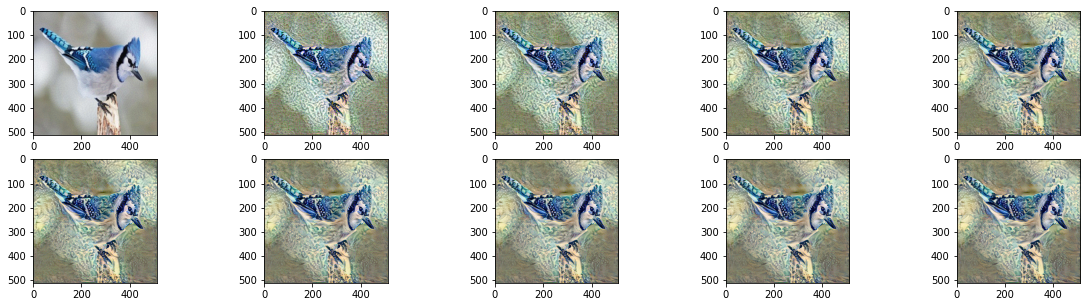

In [ ]:

best, best_loss = run_style_transfer(TargetPath, StylePath, iterations=800)

VGG-19 Output

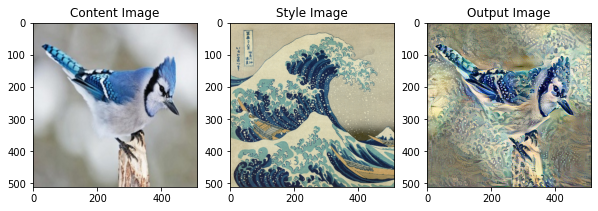

In [ ]:
plt.figure(figsize=(10, 5))
content = loadImage(TargetPath) 
style = loadImage(StylePath)
plt.subplot(1, 3, 1)
imshow(content, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style, 'Style Image')


plt.subplot(1, 3, 3)
plt.imshow(best)
plt.title('Output Image')
plt.savefig('VGG1024')
plt.show()

Res-Net50 Implementation

---



In [ ]:
def preProcessing(imgPath):
  img = loadImage(imgPath)
  img = tf.keras.applications.resnet50.preprocess_input(img)        
  return img

In [ ]:
# Target Layer For ResNet-50
targetLayer = ['conv5_block3_3_conv'] 

# Style Layers for ResNet-50
style_layers = ['conv1_conv', 'conv2_block1_1_conv','conv2_block2_1_conv','conv3_block1_1_conv','conv3_block3_1_conv','conv4_block1_1_conv','conv4_block3_1_conv','conv5_block1_1_conv','conv5_block3_1_conv']


In [ ]:
def modelImplementation():
  vgg = tf.keras.applications.resnet50.ResNet50(include_top=False, weights='imagenet')
  vgg.trainable = False

  # Fetch Layers
  targetOut = [vgg.get_layer(name).output for name in targetLayer]
  styleOut = [vgg.get_layer(name).output for name in style_layers]
 
  # Add those layers
  Final = styleOut + targetOut
  return models.Model(vgg.input, Final)

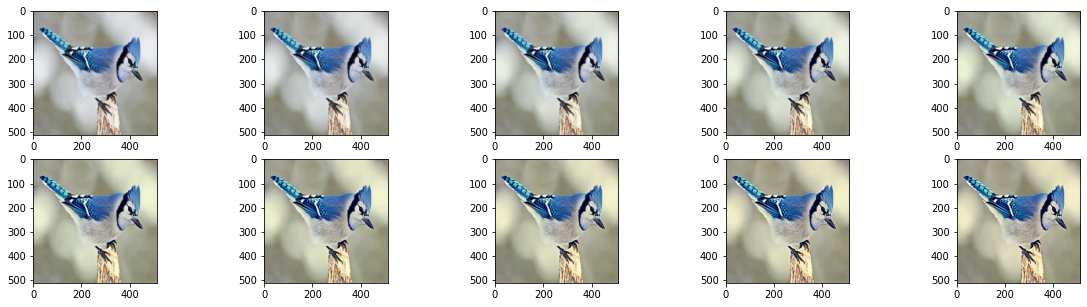

In [ ]:

best, best_loss = run_style_transfer(TargetPath, StylePath, iterations=800)

Resnet-50 Output

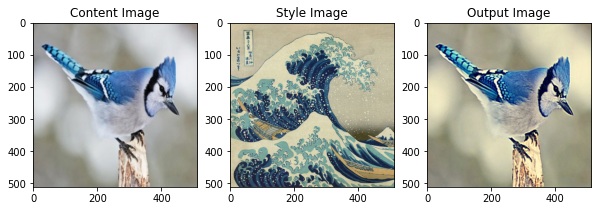

In [ ]:
plt.figure(figsize=(10, 5))
content = loadImage(TargetPath) 
style = loadImage(StylePath)
plt.subplot(1, 3, 1)
imshow(content, 'Content Image')

plt.subplot(1, 3, 2)
imshow(style, 'Style Image')


plt.subplot(1, 3, 3)
plt.imshow(best)
plt.title('Output Image')
plt.savefig('VGG1024')
plt.show()

Loss:

---


* VGG16: 

Iteration: 900

Total loss: 6.8208e+04, style loss: 2.8124e+04, content loss: 4.0083e+04, time: 0.0679s

Total time: 263.5150s
* VGG19:3.9027e+05

Iteration: 900
Total loss: 8.7064e+05, style loss: 3.5126e+05, content loss: 5.1938e+05, time: 0.0604s

* ResNet: 7.7193e+02

Iteration: 900
Total loss: 7.5355e+02, style loss: 7.5220e+02, content loss: 1.3445e+00, time: 0.0974s

Reference:


---


https://medium.com/tensorflow/neural-style-transfer-creating-art-with-deep-learning-using-tf-keras-and-eager-execution-7d541ac31398